In [1]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
from pyspark.context import SparkContext 
spark = SparkSession.builder.getOrCreate()#create spark session 
sc = spark.sparkContext#create sparkContext
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                                DecimalType,
                                LongType,
                                ArrayType,
                                TimestampType)
import pandas as pd
sample_schema = StructType([StructField("id",  IntegerType(), True),
                            StructField("timeAtServer", DoubleType(), True),
                            StructField("aircraft",  IntegerType(), True ),
                            StructField("latitude", DoubleType(), True),
                            StructField("longitude", DoubleType(), True  ),
                            StructField("baroAltitude", DoubleType(), True ),
                            StructField("geoAltitude", DoubleType(), True ),
                            StructField("numM",IntegerType(), True),
                            StructField("measurements", StringType(), True)           
                            ])
sample_aircarft = spark.read.csv("C:/PFE/TEST/training_1_category_1.csv",
                       header = True, 
                        schema = sample_schema)
sensors_schema = StructType([StructField("serial_S", LongType(), True),
                            StructField("latitudes", DoubleType(), True ),
                            StructField("longitudes",DoubleType(), True),
                            StructField("height",DoubleType(), True),
                            StructField("type", StringType(), True)
                            ])
sensors = spark.read.csv("C:/PFE/TEST/sensors.csv",
                       header = True, 
                        schema = sensors_schema)



In [2]:
from pyspark.sql.functions import isnan
sample_aircarft.na.drop(how = 'all')
sample_aircarft.dropDuplicates()
sample_aircarft_filtred=sample_aircarft.filter((sample_aircarft.latitude !=0) & (sample_aircarft.longitude != 0) & (sample_aircarft.baroAltitude != 0)& (sample_aircarft.measurements != 'NA'))
sensors.na.drop(how = 'all')
sensors.dropDuplicates()
sensors_filtred=sensors.filter((sensors.latitudes !=0) & (sensors.longitudes != 0))
#let's check our work !
sample_aircarft_filtred.filter((sample_aircarft_filtred["latitude"] == "") | sample_aircarft_filtred["latitude"].isNull() | isnan(sample_aircarft_filtred["latitude"])).count()
#Amazing  we have 0 null , nan  values !!!! 

0

In [127]:
from pyspark.sql.functions import *
sample_aircarft_filtred = sample_aircarft_filtred.withColumn("ArrayOfString", split(col("measurements"), "\],\s*\[").cast(ArrayType(StringType())).alias("ArrayOfString"))                                           
sample_aircarft_filtred = sample_aircarft_filtred.withColumn("sensors_informations",explode_outer('ArrayOfString'))
sample_aircarft_filtred=sample_aircarft_filtred.withColumn("sensors_informations", regexp_replace(col("sensors_informations"), "[\\[\\]]", ""))
sample_aircarft_filtred=sample_aircarft_filtred.withColumn("sensors_informations",split(col("sensors_informations"), ",\s*").cast(ArrayType(IntegerType())).alias("sensors informations"))
sample_aircarft_filtred = sample_aircarft_filtred.withColumn("serial_F",sample_aircarft_filtred["sensors_informations"].getItem(0))
sample_aircarft_filtred = sample_aircarft_filtred.withColumn("timestamp",sample_aircarft_filtred["sensors_informations"].getItem(1))
sample_aircarft_filtred= sample_aircarft_filtred.withColumn("signalstrength",sample_aircarft_filtred["sensors_informations"].getItem(2))


In [125]:
#==>Data integration: Using multiple databases
#spatial join sesnors data + aircrafts data , i used inner join 
joined_aircarft_sensors=sample_aircarft_filtred.join(sensors_filtred, sample_aircarft_filtred.serial_F == sensors_filtred.serial_S, 'inner')


In [126]:
#==>Data dimensionality reduction:we will reduce baroaltidue ,measurments , arrayofsting , sensorinfo,serial_S columns 
joined_aircarft_sensors=joined_aircarft_sensors.select('id','timeAtServer','aircraft','latitude','longitude','geoAltitude','baroAltitude','numM','serial_F','timestamp','signalstrength','latitudes','longitudes','height','type')


# Data Transformation and New Data Calculus
Data transformation (also called feature engineering) is a set of actions that covers 
transformation of the processed data. 
Engineering features from your data can use some time, 
but they can enhance the machine learning performance

create new columns :

-sensor_geohash : geohash Localisation of  sensor

-distance2d: distance between the sensor and the aircraft considering lat and lon

-distance3d:distance between the sensor and the aircraft considering lat and lon and alt

-aircarft_geohash: geohash Localisation of  aircraft

-delta_geo_alt_sensor_aircraft:difference in geoaltitudes between sensor and aircraft

# Geohash Calculus

In [6]:
import geohash2
import pyspark.sql.functions as F
from pyspark.sql.types import *
import pandas as pd
from math import radians, cos, sin, asin, sqrt
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
#to create geohash positions we  need float num (lat, long)
joined_aircarft_sensors.baroAltitude.cast(DoubleType())
joined_aircarft_sensors.geoAltitude.cast(DoubleType())
joined_aircarft_sensors.height.cast(DoubleType())
joined_aircarft_sensors.latitude.cast(DoubleType()) 
joined_aircarft_sensors.longitude.cast(DoubleType()) 
joined_aircarft_sensors.latitudes.cast(DoubleType()) 
joined_aircarft_sensors.longitudes.cast(DoubleType()) 
#we will create geohash with precision of 12 bit 
udf1 = F.udf(lambda x,y: geohash2.encode(x,y,precision=12))
udf2= F.udf(lambda x,y,z,t: geodesic((x,y),(z,t)))
joined_aircarft_sensors=joined_aircarft_sensors.withColumn('Geohash_aircraft', udf1('latitude','longitude'))
joined_aircarft_sensors=joined_aircarft_sensors.withColumn('Geohash__sensors', udf1('latitudes','longitudes'))
joined_aircarft_sensors.show(2)

+---+------------+--------+----------------+----------------+-----------+------------+----+--------+---------+--------------+---------+----------+-------+-------+----------------+----------------+
| id|timeAtServer|aircraft|        latitude|       longitude|geoAltitude|baroAltitude|numM|serial_F|timestamp|signalstrength|latitudes|longitudes| height|   type|Geohash_aircraft|Geohash__sensors|
+---+------------+--------+----------------+----------------+-----------+------------+----+--------+---------+--------------+---------+----------+-------+-------+----------------+----------------+
|  1|         0.0|    1787|49.5238952636719|7.80282271535773|    6537.96|      6400.8|   3|     463|963309455|             4|49.471601|  7.696532|273.985|GRX1090|    u0v99x9cdgnq|    u0v3rnh2yny4|
|  1|         0.0|    1787|49.5238952636719|7.80282271535773|    6537.96|      6400.8|   3|     424|963315122|            27| 49.42498|   7.75332|277.015|GRX1090|    u0v99x9cdgnq|    u0v90mtc3kn3|
+---+----------

# Distance2D-Distance3D-delta_geo_alt_sensor_aircraft Calculus
We have two method to calculate distance betwen two point :haversine vs geodisc(vincenty)
==> Vincenty is more accurate 

In [18]:
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

def get_distance_2d(lat_1, lng_1, lat_2, lng_2): 
    A =(lat_1, lng_1)
    B = (lat_2, lng_2)
    d=geodesic(A, B).meters
    return d
def get_distance_3d(distance_2d, alt1, alt2): 
    distance_3d = sqrt(distance_2d**2+(alt2-alt1)**2)
    return  distance_3d
def get_Difference( alt1, alt2): 
    Difference= alt1-alt2
    return Difference
udf_get_distance_2d = F.udf(get_distance_2d)
udf_get_distance_3d = F.udf(get_distance_3d)
udf_get_Difference = F.udf(get_Difference)
joined_aircarft_sensors=joined_aircarft_sensors.withColumn('Distance_2d', udf_get_distance_2d('latitude','longitude','latitudes','longitudes').cast(DoubleType()))
joined_aircarft_sensors.Distance_2d.cast(DoubleType())
joined_aircarft_sensors=joined_aircarft_sensors.withColumn('Distance_3d', udf_get_distance_3d('Distance_2d','geoAltitude','height').cast(DoubleType()))
#6)delta_geo_alt_sensor_aircraft, difference in altitudes that of the sensor and that of the aircraft
#7)delta_geo_baro_alt, difference between the baro and geo altitudes of the aircraft
joined_aircarft_sensors=joined_aircarft_sensors.withColumn('delta_geo_alt_sensor_aircraft', udf_get_Difference('geoAltitude','height'))
joined_aircarft_sensors=joined_aircarft_sensors.withColumn('delta_geo_baro_alt', udf_get_Difference('geoAltitude','baroAltitude'))
joined_aircarft_sensors.Distance_3d.cast(DoubleType())
joined_aircarft_sensors.select('Geohash_aircraft','Geohash__sensors','Distance_3d').show(3)

+----------------+----------------+------------------+
|Geohash_aircraft|Geohash__sensors|       Distance_3d|
+----------------+----------------+------------------+
|    u0v99x9cdgnq|    u0v3rnh2yny4|11504.344974715948|
|    u0v99x9cdgnq|    u0v90mtc3kn3|13156.682403385497|
|    u0v99x9cdgnq|    u0v2mh90ct7g|30604.046409106202|
+----------------+----------------+------------------+
only showing top 3 rows



# Summary statistics of our new column 

In [22]:
joined_aircarft_sensors.select('Distance_3d').describe().show()

+-------+-----------------+
|summary|      Distance_3d|
+-------+-----------------+
|  count|          5605604|
|   mean|123938.2030413138|
| stddev|77746.93135666501|
|    min|814.0754814442822|
|    max| 987143.325966745|
+-------+-----------------+



# Data Discretization/Histograms of 3d Distance:
Histograms are a great way to visualize the distributions of a single variable and it is an  initial exploratory analysis with fewer variables.

In [59]:
import plotly.offline as py
import plotly.graph_objs as go
import pandas as pd
import requests
joined_aircarft_sensors.createOrReplaceTempView("joined_aircarft_sensors")
DF_3D= spark.sql("SELECT id,Distance_3d from joined_aircarft_sensors ")

In [86]:
#due the bad performance of my laptop i will take a sample with fraction of 0.2=20% of data  and seed of 20
DF_3D=DF_3D.sample(False, 0.2, 20)
DF_3D.show(3)

+---+------------------+
| id|       Distance_3d|
+---+------------------+
| 82|35742.512186461805|
|108|223191.67280533674|
|128|117693.69105898959|
+---+------------------+
only showing top 3 rows




==>it's defined as a process of converting continuous data attribute values into a finite set of intervals with minimal loss of information.

-Distances’ Discretization

-Signals Strengths Discretization

-Altitudes’Discretization

- Choice of the number of classes k = 1 + log2 (num of sample alt = N)

- The histogram representation consists in grouping the "close" observations into classes:

- We sort the vector x (denoted x), and we partition the interval] a0; ak]

- (a0 <x 1; ak> x n) in k intervals] ai-1; have] called classes.

- The width of class i is noted hi = ai- (ai-1) (and h = (ak -a0) / k if not fixed).

- N = count | 5605604

- Choice of the number of classes k = 1 + log2 (5605604)=7.748

- a0 = min | 814.0754814442822 = 814

- ak = max | 987143.325966745 =  987143

- h = (ak -a0) / k

k = 8

h = 123291


#Binning our data , we can use also use cut() with pandas if we have  small sample 

#this work will be repeated for the rest of all the column  we want to bin and discretize

In [117]:
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import udf
from pyspark.sql.types import *

float_distance = F.udf(lambda x: float(x), DoubleType() )
bucketizer = Bucketizer(splits=[ 0, 123291, 246582,369873,493164,616455,739746,863037,986328,float('Inf') ],inputCol="Distance_3d", outputCol="Discret_3d")

joined_aircarft_sensors_3d = bucketizer.setHandleInvalid("skip").transform(DF_3D)

def categorizer(Distance_3d):
    if Distance_3d < 123291:
        return "A"
    elif Distance_3d <  246582:
        return "B"
    elif Distance_3d < 369873:
        return "C"
    elif Distance_3d < 493164:
        return "D"
    elif Distance_3d < 616455:
        return "E"
    elif Distance_3d < 739746:
        return "F"
    elif Distance_3d < 863037:
        return "G"
    else: 
        return "H"
bucket_udf = udf(categorizer, StringType() )
joined_aircarft_sensors_3d = joined_aircarft_sensors_3d.withColumn("Discret_3d_ordinal", bucket_udf("Distance_3d"))
joined_aircarft_sensors_3d.select("Distance_3d",'Discret_3d','Discret_3d_ordinal').show(5)

+------------------+----------+------------------+
|       Distance_3d|Discret_3d|Discret_3d_ordinal|
+------------------+----------+------------------+
|35742.512186461805|       0.0|                 A|
|223191.67280533674|       1.0|                 B|
|117693.69105898959|       0.0|                 A|
|101726.07707472403|       0.0|                 A|
| 83620.47134375844|       0.0|                 A|
+------------------+----------+------------------+
only showing top 5 rows



In [120]:
t=joined_aircarft_sensors_3d.groupBy("Discret_3d_ordinal").count()
t.show()

+------------------+-----+
|Discret_3d_ordinal|count|
+------------------+-----+
|                 E|    1|
|                 B| 2183|
|                 D|   55|
|                 C|  457|
|                 A| 3304|
+------------------+-----+



In [121]:
import plotly.graph_objs as go
import pandas as pd
import requests
import matplotlib.pyplot as plt

#We can also use matplotlib and Pandas to visualize the total number of each class a,b,c,d,e,f,g,h
import pandas as pd

%matplotlib inline
t_pandas_DataFrame = pd.DataFrame.from_records(t.collect(), columns=t.columns)
t_pandas_DataFrame.head(5)

,Discret_3d_ordinal,count
0,E,1
1,B,2183
2,D,55
3,C,457
4,A,3304


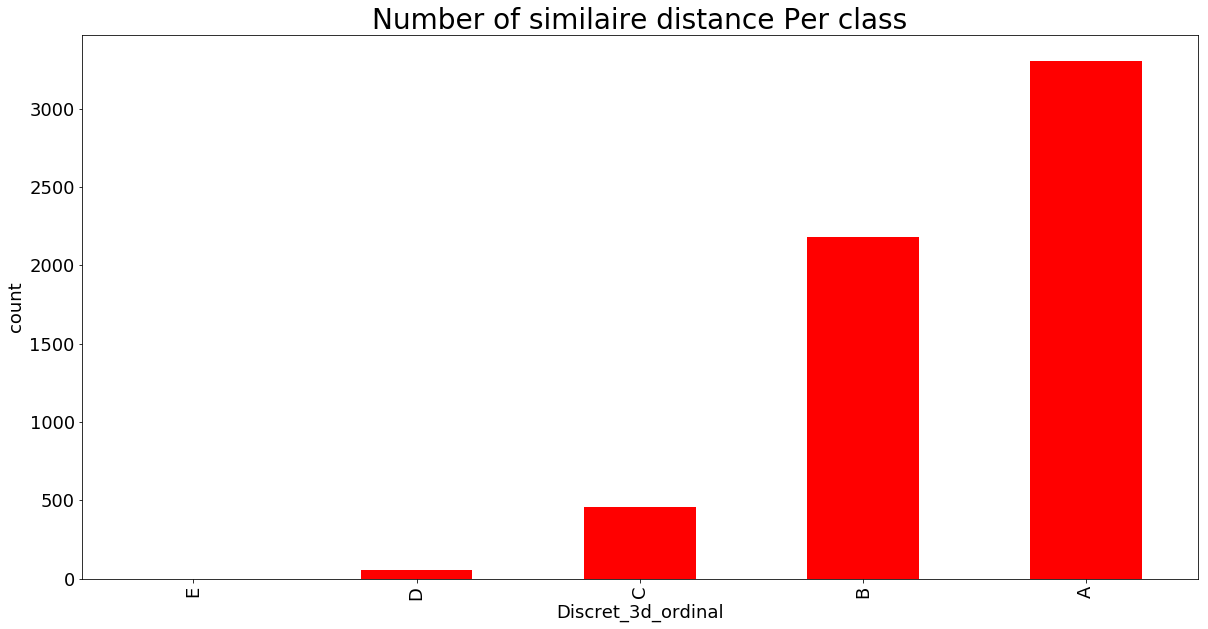

In [122]:
t_pandas_DataFrame = t_pandas_DataFrame.sort_values(by ='count' )
t_pandas_DataFrame.plot(figsize = (20,10), kind = "bar", color = "red",
                               x = "Discret_3d_ordinal", y = "count", legend = False)

plt.xlabel("Discret_3d_ordinal", fontsize = 18)
plt.ylabel("count", fontsize = 18)
plt.title("Number of similaire distance Per class", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()